# Setup

In [1]:
%reload_ext autoreload

In [2]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [3]:

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
import scipy.stats
import einops
from functools import partial

from functools import partial
from collections import namedtuple
import itertools
from itertools import repeat
from time import time
import chex
import typing
from typing import Any, Callable, Sequence

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import lax, random, numpy as jnp
import jax.scipy as jsp

from flax.core import freeze, unfreeze
from flax import linen as nn
import flax

import jaxopt
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import torch
from torch.utils.data import TensorDataset, DataLoader

import distrax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

#jax.config.update("jax_enable_x64", False)


import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression

2022-10-17 17:58:05.906756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-10-17 17:58:06.265247: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-17 17:58:12.367450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-10-17 17:58:12.367647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


In [5]:
import os 
cpu_count = os.cpu_count()
print(cpu_count)

# Run jax on multiple CPU cores
# https://github.com/google/jax/issues/5506
# https://stackoverflow.com/questions/72328521/jax-pmap-with-multi-core-cpu
import os 
#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=90'

import jax
print(jax.devices())

96
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


# Code

In [113]:
%pwd

[autoreload of shifty.tta.estimators failed: Traceback (most recent call last):
  File "/home/kpmurphy/mambaforge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/kpmurphy/mambaforge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/home/kpmurphy/mambaforge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/kpmurphy/mambaforge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/kpmurphy/mambaforge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/home/kpmurphy/mambaforge/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 289, in update_function
    setattr(old, nam

'/home/kpmurphy/github/shifty'

In [6]:
from shifty.tta.label_space import *
from shifty.tta.data_generator import *
from shifty.tta.tta import *
from shifty.tta.estimators import *
from shifty.tta.estimators_test import *

from shifty.skax.logreg_flax import *
from shifty.skax.skax import *



In [48]:


from shifty.tta.data_generator import *

FrozenDict({
    params: {
        layers_0: {
            bias: DeviceArray([ 0.493, -1.186,  0.155,  0.538], dtype=float32),
            kernel: DeviceArray([[-2.12 , -1.653,  1.023,  1.135],
                         [-7.389,  6.017, -6.59 ,  5.484]], dtype=float32),
        },
    },
})
max error of logreg = 0.493


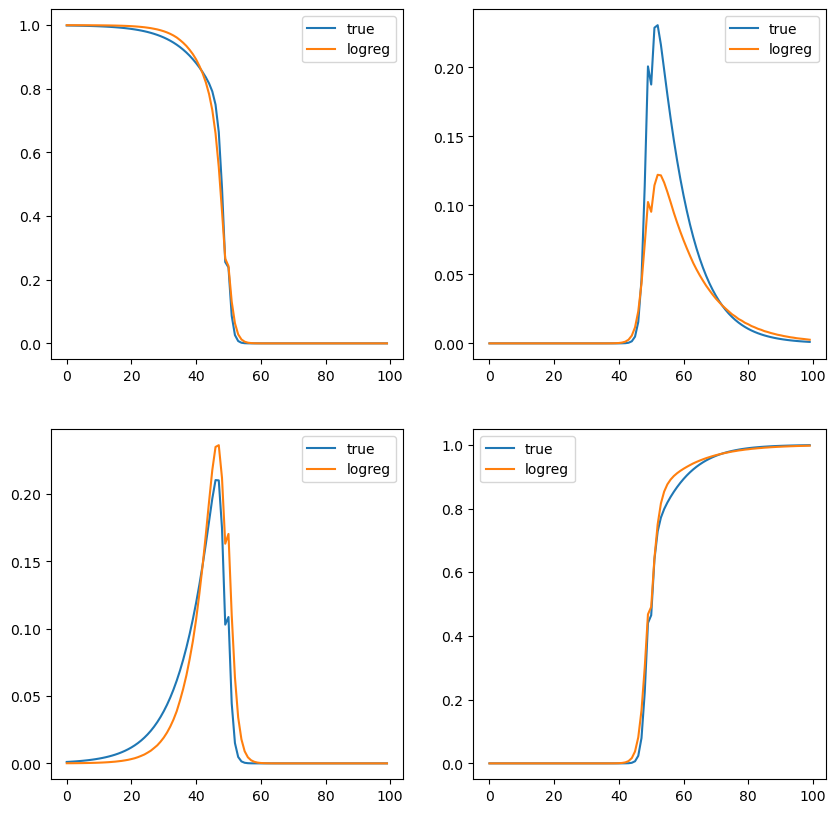

In [25]:


key = jr.PRNGKey(42)
corr_source = 0.3
ls = LabelSpace(nclasses=2, nfactors=2)
src_dist = PlantDataGenerator(key, corr_source, ls, sf=10)

X_train, y, a = src_dist.sample(key, 500)
mix_train = ls.flatten_labels(y, a)
mix_post_true = src_dist.predict_joint(X_train)

model = make_logreg(4)
model.fit(X_train, mix_train)

print(model.params)

# evaluate on a dense grid
xs, x1, x2 = make_xgrid(npoints = 100)
mix_post_true = src_dist.predict_joint(xs)
mix_post_pred = model.predict(xs)

name = 'logreg'
print('max error of {} = {:.3f}'.format(name, jnp.max(mix_post_true - mix_post_pred)))
plot_posteriors({'true': mix_post_true, name: mix_post_pred})



In [56]:
print(src_dist.params.Sigmas.shape)

(4, 2, 2)


In [54]:
key = jr.PRNGKey(42)
corr_source = 0.3
ls = LabelSpace(nclasses=2, nfactors=2)
src_dist = PlantDataGenerator(key, corr_source, ls, sf=5)
Xs, Ys, As = src_dist.sample(key, 500)

key = jr.PRNGKey(0)
ls = LabelSpace(nclasses=2, nfactors=2)
label_noise = 1; attribute_noise = 0.1; label_ndims = 1; attribute_ndims = 1;
def make_dist(key, rho):
    src_dist = PlantDataGeneratorMultiDim(key, rho, ls, 
    label_noise, attribute_noise, label_ndims, attribute_ndims)
    return src_dist

ntrials = 5
nsource_samples = 500
ntarget_samples = 100

src_dist = make_dist(key, 0.3)

Xs, Ys, As = src_dist.sample(key, nsource_samples)



clf = make_logreg
estimator = UndaptedEstimator(clf, ls)
#estimator = EMEstimator(clf, ls)

estimator.fit_source(Xs, Ys, As, src_dist)

corr = 0.9
target_dist = deepcopy(src_dist)
target_dist.shift_prior_correlation(corr)
Xt, Yt, At = target_dist.sample(key, 100)
true_prob = target_dist.predict_class(Xt)
estimator.fit_target(Xt, target_dist)
pred_prob = estimator.predict_class_target(Xt)

y_test  = Yt
prob_vector = pred_prob[:,1]


fpr_sklearn, tpr_sklearn, thresholds_sklearn = sklearn.metrics.roc_curve(y_test, prob_vector)
auc_sklearn = sklearn.metrics.roc_auc_score(y_test, prob_vector)
fpr_kpm, tpr_kpm, thresholds_kpm = roc(y_test, prob_vector)
auc_kpm = roc_auc(y_test, prob_vector)


plt.figure()
plt.scatter(fpr_sklearn, tpr_sklearn, s=100, alpha=0.5, color="blue", label="Scikit-learn")
plt.scatter(fpr_kpm, tpr_kpm, color="red", s=100, alpha=0.3, label="Our implementation")
plt.title("ROC Curve: AUC sklearn {:.3f}, us {:.3f}".format(auc_sklearn, auc_kpm))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()



ValueError: multivariate_normal requires cov.shape == (..., n, n) for n=1, but got cov.shape == (500, 2, 2).

oracle
oracle-prior


/home/kpmurphy/mambaforge/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


unadapted
unadapted-joint
em
(3, 5, 2)


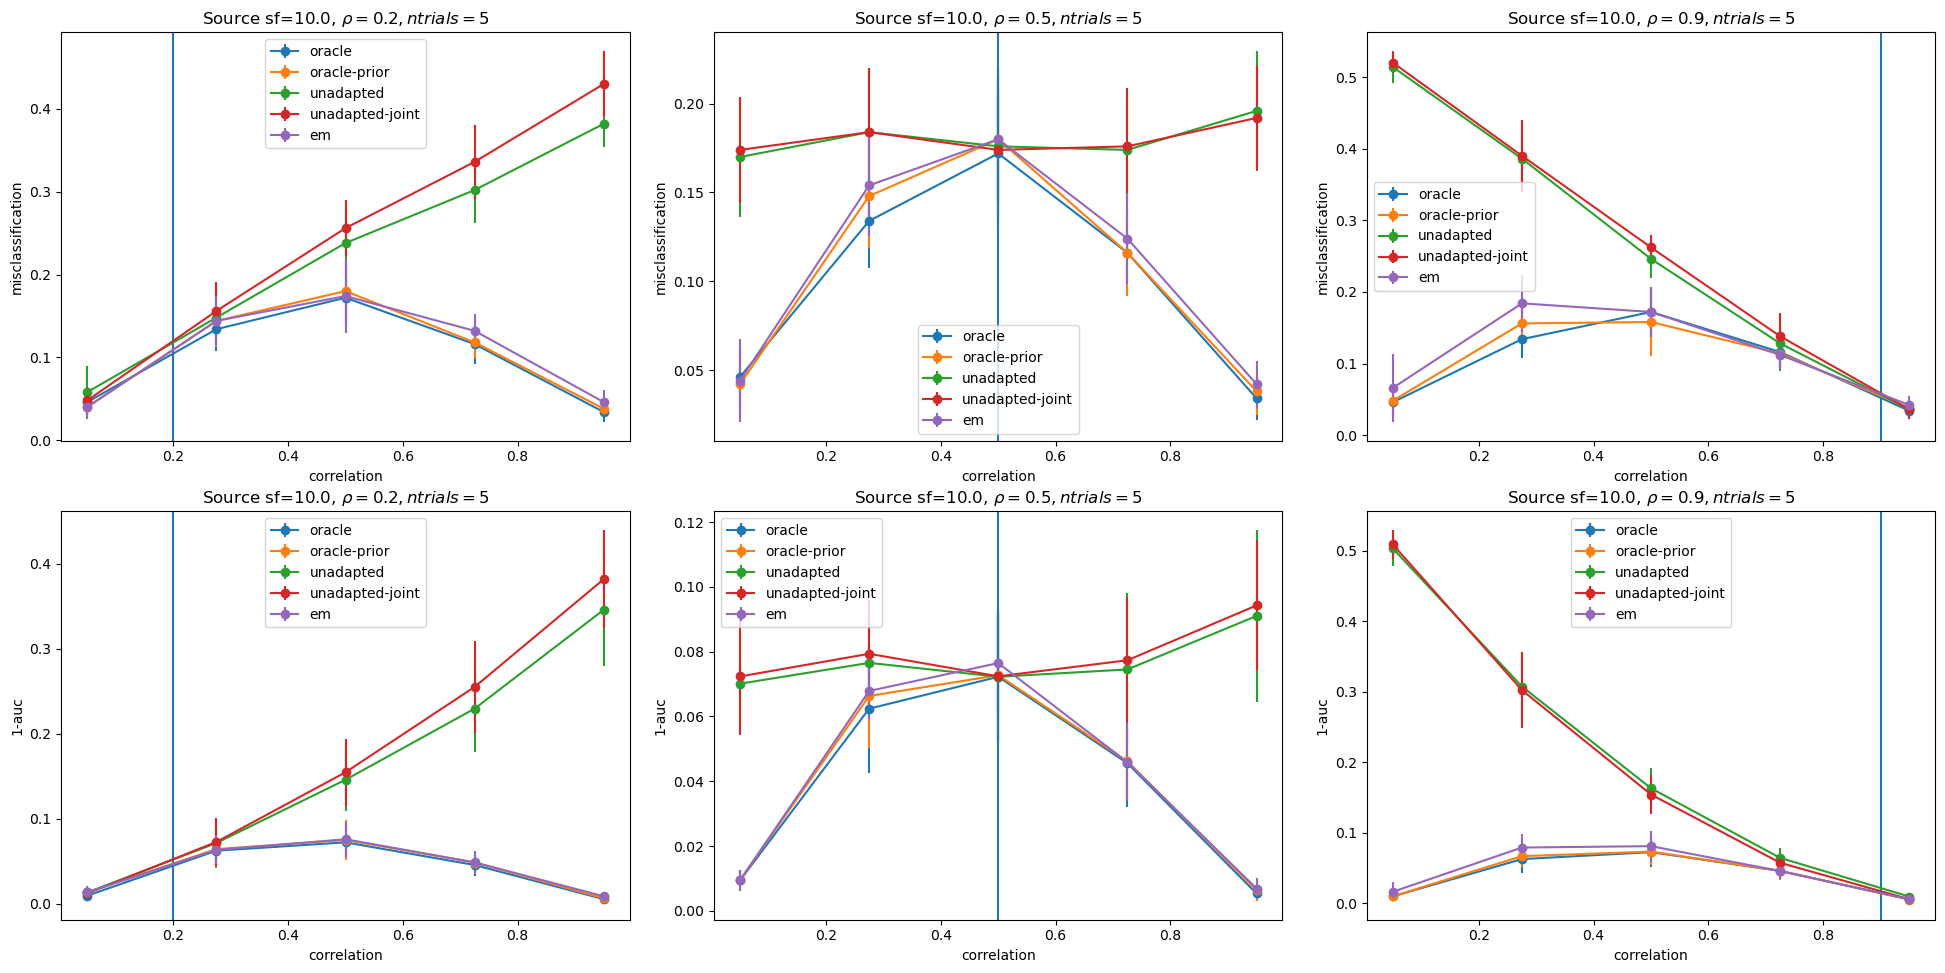

In [41]:
key = jr.PRNGKey(0)
ls = LabelSpace(nclasses=2, nfactors=2)
sf = 10
def make_dist(key, rho):
    src_dist = PlantDataGenerator(key, rho, ls, sf=sf)
    return src_dist
corr_sources = jnp.array([0.2, 0.5, 0.9])
corr_targets = np.linspace(0.05, 0.95, num=5)
ntrials = 5
nsource_samples = 500
ntarget_samples = 100
clf = make_logreg


methods = {
'oracle': OracleEstimator(ls),
'oracle-prior': OraclePriorEstimator(clf, ls),
'unadapted': UndaptedEstimator(clf, ls),
'unadapted-joint': UndaptedEstimatorJoint(clf, ls),
'em': EMEstimator(clf, ls)
}

losses_mean = {}
losses_std = {}
for name, estimator in methods.items():
    print(name)
    losses_mean[name], losses_std[name] = evaluate_estimator(key, make_dist,
        corr_sources, corr_targets, ntrials, estimator, nsource_samples, ntarget_samples)

print(losses_mean['unadapted'].shape) # (nsources, ntargets, nmetrics)


nsources = len(corr_sources)
metric_names = ['misclassification','1-auc']
nmetrics = len(metric_names)
fig, axs = plt.subplots(nmetrics, nsources, figsize=(20,10))
fig.tight_layout(pad=3.0)
for m in range(nmetrics):
    for s in range(nsources):
        ax = axs[m,s]
        corr_source = corr_sources[s]
        for name in methods.keys():
            ax.errorbar(corr_targets, losses_mean[name][s,:,m], yerr=losses_std[name][s,:,m], marker='o', label=name)
        ax.set_xlabel('correlation')
        ax.set_ylabel(metric_names[m])
        ax.set_title(r'Source sf={:0.1f}, $\rho={:0.1f}, ntrials={}$'.format(sf, corr_source, ntrials))
        ax.legend()
        ax.axvline(x=corr_source)

In [49]:
key = jr.PRNGKey(0)
ls = LabelSpace(nclasses=2, nfactors=2)
label_noise = 1; attribute_noise = 0.1; label_ndims = 1; attribute_ndims = 1;
def make_dist(key, rho):
    src_dist = PlantDataGeneratorMultiDim(key, rho, ls, 
    label_noise, attribute_noise, label_ndims, attribute_ndims)
    return src_dist
corr_sources = jnp.array([0.2, 0.5, 0.9])
corr_targets = np.linspace(0.05, 0.95, num=5)
ntrials = 5
nsource_samples = 500
ntarget_samples = 100
clf = make_logreg


methods = {
'oracle': OracleEstimator(ls),
'oracle-prior': OraclePriorEstimator(clf, ls),
'unadapted': UndaptedEstimator(clf, ls),
'unadapted-joint': UndaptedEstimatorJoint(clf, ls),
'em': EMEstimator(clf, ls)
}

losses_mean = {}
losses_std = {}
for name, estimator in methods.items():
    print(name)
    losses_mean[name], losses_std[name] = evaluate_estimator(key, make_dist,
        corr_sources, corr_targets, ntrials, estimator, nsource_samples, ntarget_samples)

print(losses_mean['unadapted'].shape) # (nsources, ntargets, nmetrics)


nsources = len(corr_sources)
metric_names = ['misclassification','1-auc']
nmetrics = len(metric_names)
fig, axs = plt.subplots(nmetrics, nsources, figsize=(20,10))
fig.tight_layout(pad=3.0)
for m in range(nmetrics):
    for s in range(nsources):
        ax = axs[m,s]
        corr_source = corr_sources[s]
        for name in methods.keys():
            ax.errorbar(corr_targets, losses_mean[name][s,:,m], yerr=losses_std[name][s,:,m], marker='o', label=name)
        ax.set_xlabel('correlation')
        ax.set_ylabel(metric_names[m])
        ax.set_title(r'Source sf={:0.1f}, $\rho={:0.1f}, ntrials={}$'.format(sf, corr_source, ntrials))
        ax.legend()
        ax.axvline(x=corr_source)

oracle


ValueError: multivariate_normal requires cov.shape == (..., n, n) for n=1, but got cov.shape == (500, 2, 2).

In [52]:
label_noise = 1; attribute_noise = 0.1; label_ndims = 1; attribute_ndims = 1;
z = 2;
mu, Sigma = class_cond_params_plant_multidim(z, label_noise, attribute_noise, label_ndims, attribute_ndims)

print([mu.shape, Sigma.shape])

[(2, 1), (2, 2)]
